# Week 2 Part 1 - Network Analysis: Graph Theory, Definitions 
### Assignment3: Graph Visualization (DATA620)

##### Authors: John Mazon, Leticia Cancel, Bharani Nittala 

# Import Libraries

In [1]:
import networkx as nx
import numpy as np
import pylab as pl
import scipy as sp
import time
import random
import queue
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

#in this section we import the needed packages, among them 

#NetworkX which is a Python package for the creation, manipulation, and study of the structure, dynamics, 
#and functions of complex networks.


#NumPy is a Python library used for working with arrays.It also has functions for working in domain of linear algebra, 
#fourier transform, and matrices.

#combining both the PyPlot and NumPy namespaces into a single one (to avoid having to import two namespaces), 
#the result is PyLab.

#SciPy is a scientific computation library that uses NumPy underneath.SciPy stands for Scientific Python.
#It provides more utility functions for optimization, stats and signal processing.Like NumPy, SciPy is open source so we can use it freely.

### Intro

Assignment Part1-

"Load a graph database of your choosing from a text file or other source. If you take a large network dataset from the web (such as from https://snap.stanford.edu/data/), please feel free at this point to load just a small subset of the nodes and edges."

We loaded a graph database of our choosing from source. We used a large network dataset from the web (such as from https://snap.stanford.edu/data/), 
we loaded just a small subset of the nodes and edges.

Background - 

title: Amazon product co-purchasing network and ground-truth communities

Network was collected by crawling Amazon website. It is based on Customers Who Bought This Item Also Bought feature of the Amazon website. If a product i is frequently co-purchased with product j, the graph contains an undirected edge from i to j. Each product category provided by Amazon defines each ground-truth community. 

We regard each connected component in a product category as a separate ground-truth community. We remove the ground-truth communities which have less than 3 nodes. We also provide the top 5,000 communities with highest quality which are described in our paper. As for the network, we provide the largest connected component.



+ Location of data for draw graph
 

# Read network from text file

Below we specify file path locations. we imported our graph plus the communities. essentially reading in graph file into string by specifying file path(location). We see both unfiltered vs. filtered into communities. 

our graph file appears as tab delimited text file

In [2]:
data_loc=r'C:/Users/pc/Desktop/old desk/Documents/Data 620/Assignment2/'
graph_file=data_loc+ 'com-amazon.ungraph.txt'  
com_file=data_loc+'com-amazon.all.dedup.cmty.txt'
top_com_file=data_loc+'com-amazon.top5000.cmty.txt'

+ Load graph from text files

below we are reading in whole thing. using networkx read_edgelist(which are pairs of nodes that represent edges)

note:
- the NODES are products purchased
- shows how many customers have purchased products together, if customers purchased two products together it forms an EDGE
- we see products similar to each other purchased together have more edges between them


In [3]:
g = nx.read_edgelist(graph_file)

- by using networkx "read_edgelist" we are reading in the whole graph tab delimited file(from com-amazon.ungraph) into g
- the ungraphed file can be thought of as products represented as numbers
- we start off by using g.order() which we put into N, ORDER of graph is number of nodes
- then using g.size() we put into K, SIZE is number of edges
- now we can calculate average degree:

The average degree of an undirected graph is the sum of the degrees of all its nodes divided by the number of nodes in the graph. It is a measure of the connectedness of a graph.
- from here we are able to obtain basic statistics of the graph 'g'

In [4]:
# find number of nodes and edges 
N,K=g.order(),g.size()
avg_deg=K/N
# Display number of nodes and edges
print('Number of nodes of the graph: ',N)
print('Number of edges of the graph: ',K)
print('Average degree : ',avg_deg)

Number of nodes of the graph:  334863
Number of edges of the graph:  925872
Average degree :  2.7649277465709856


In [5]:
# Density of graph
# density of graph is how many of all possible edges exist in the graph
#example
#Density is defined as the number of connections a participant has, divided by the total possible connections
#a participant could have.

density=nx.density(g)
print('Network density: ',density)

Network density:  1.6513834036534368e-05


In [6]:
# finding triadic closure

# definition: Triadic Closure for a Graph is the tendency for nodes who has a common neighbour to have an edge between them. 
#In case more edges are added in the Graph, these are the edges that tend to get formed.

triadic_closure = nx.transitivity(g)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.20522444916452579


In [15]:
# DEGREE 
# is a property of each node. in other words, how many edges does each node have. 
# below we define a dictionary [which helps return later a dictionary where we've calculated a degree, 
#then storing those numbers back into the graph]
# ***Dictionaries**** are used to store data values in key:value pairs.
# set_nodes_attributes takes the dictionary values and sticks the values into the graph and calls property 'degree'
# Again, later on we can go back to the graph and ask for the degree of each node

degree_dict = dict(g.degree(g.nodes()))
nx.set_node_attributes(g, degree_dict, 'degree')
degrees_vals = sorted(degree_dict.items(), key = lambda x: x[1], reverse=True)
print("Top 20 nodes by degree:")
for d in degrees_vals[:20]:
    print(d)
# using above code we are able to sort the nodes by our values[top 20]

#using the degrees we stored in the dictionary, we sort the list by values. 
#example : node '548091' has 549 edges

Top 20 nodes by degree:
('548091', 549)
('458358', 324)
('222074', 257)
('199628', 230)
('515301', 228)
('291117', 219)
('502784', 217)
('296016', 212)
('239107', 205)
('436020', 197)
('239327', 196)
('454004', 196)
('399944', 180)
('45146', 179)
('430936', 177)
('21209', 171)
('98756', 165)
('501444', 163)
('194384', 160)
('55387', 158)


In [9]:
# Clustering coefficient
# Local Clustering Coefficient of a node in a Graph is the fraction of pairs 
#of the node's neighbours that are adjacent to each other.
clust_coefficients = nx.clustering(g)
print(type(clust_coefficients))
avg_clust = sum(clust_coefficients.values()) / len(clust_coefficients)
print(avg_clust)

<class 'dict'>
0.3967463932787655


In [16]:
# function for get subgraph
#Subgraph Breadth First Search
#This can be throught of as being like Dijkstra's algorithm for shortest paths, but with every edge having the same length.
#However it is a lot simpler and doesn't need any data structures. 
#We just keep a tree (the breadth first search tree), a list of nodes to be added to the tree, 
#and markings (Boolean variables) on the vertices to tell whether they are in the tree or list.

#created subgraph by using breadth first search between a pair of nodes. we start at one node and we walk through the graph

#can think of as, start at one product and pull out all things that are one degree connected to it

def get_subgraph_bfs(graph, start_node, num_node):
    node_set = set()
    probbed = {start_node}
    bfs_queue = queue.deque()
    bfs_queue.append(start_node)
    while len(bfs_queue) > 0:
        i = bfs_queue.popleft()
        node_set.add(i)
        for j in g[i]:
            if j not in probbed:
                probbed.add(j)
                bfs_queue.append(j)
        if len(node_set) >= num_node:
            return nx.subgraph(graph, node_set)

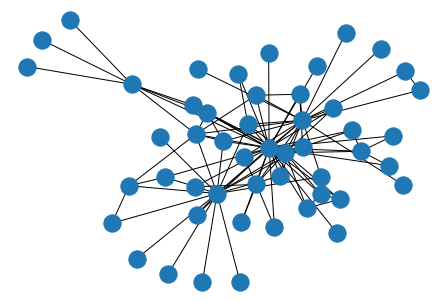

In [12]:
# get subgraph with 50 nodes
#start at node one and pull 50 closest nodes

subgraph = get_subgraph_bfs(g, '1', 50)
# draw subgraph

nx.draw(subgraph)
plt.savefig("subgraph.png")

In [13]:
# get DIAMETER of subpgraph
#The diameter of a graph is the "maximum eccentricity" of any vertex in the graph.
#That is, the greatest distance between any pair of vertices or, alternatively
#To find the diameter of a graph, first find the shortest path between each pair of vertices.
d=nx.diameter(subgraph)
print('Diameter of the subgraph: ',d)

Diameter of the subgraph:  4


+ Graph label extraction

In [17]:
nx.write_gexf(subgraph, 'C:/Users/pc/Desktop/old desk/Documents/Data 620/Assignment2/network.gexf')